In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.color import rgb2gray
%matplotlib inline

from sklearn import metrics
import matplotlib.image as mpimg
import random
from scipy import interp
from itertools import cycle
import datetime 

import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class ASL_Dataset(Dataset):
    def __init__(self, X, y):
      
        X_2d = []
        for i in X:
              X_2d.append(i.reshape(1, 50, 50))
        X_2d = np.array(X_2d)
    
        # Convert data & labels from numpy to PyTorch format
        data = torch.FloatTensor(X_2d)
        #data = data.permute(0,3,1,2)        
        labels = torch.LongTensor(y)        

        # Store data as part of the class        
        self.data = data
        self.labels = labels
        
    def __len__(self):
      
        # Calculate and return the number of samples in the dataset
        return(len(self.labels))
        
    def __getitem__(self, idx):
        
        return self.data[idx], self.labels[idx]

In [0]:
# https://www.kaggle.com/justuser/sign-language-classifier-convnet-with-pytorch
 class Network(nn.Module):   
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 15, 3) #15 or 20
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(15, 20, 3) #20 or 30
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(20 * 9 * 9, 270) 
        self.fc4 = nn.Linear(270, 9) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 20 * 9 * 9) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

In [0]:
###############################################################################
# Function:     LoadMNIST()
# Inputs:       N/A
# Output:       X   - MNIST images
#               y   - MNIST labels
# Description:  This function loads the MNIST training and testing images. We 
#               will combine both sets in order to create one big dataset, and
#               then reduce the size as to not overfit our model with the
#               MNIST data. The images for letters C, G, H are different 
#               formats so we will discard of these images.
###############################################################################

def LoadMNIST():

    # Load data
    data_raw = pd.read_csv("drive/My Drive/sign_mnist_train.csv")
    test_data_raw = test = pd.read_csv("drive/My Drive/sign_mnist_test.csv")

    # Break up data and labels
    labels = data_raw['label']
    data_raw.drop('label', axis=1, inplace=True)
    labels_test = test_data_raw['label']
    test_data_raw.drop('label', axis=1, inplace=True)

    # Normalize data
    data_full = data_raw.values/255
    labels_full = labels.values
    test_data_full = test_data_raw.values/255 
    labels_test_full = labels_test.values 

    # Concatenate training and test set
    X_MNIST_full = np.concatenate((data_full, test_data_full))
    y_MNIST_full = np.concatenate((labels_full, labels_test_full))

    # Get rid of unused letters and the letters c, g, and h
    X_MNIST = []
    y_MNIST = []
    for i in range(len(y_MNIST_full)):
        if (y_MNIST_full[i] <= 8 and y_MNIST_full[i] != 2 and y_MNIST_full[i] != 6 and y_MNIST_full[i] != 7):
            X_MNIST.append(X_MNIST_full[i])
            y_MNIST.append(y_MNIST_full[i])
    X_MNIST = np.asarray(X_MNIST)
    y_MNIST = np.asarray(y_MNIST)

    # Reshape data to 50x50
    X_MNIST_50 = []
    for i in range (len(X_MNIST)):
        img_flat_orig = X_MNIST[i];
        img_2d_orig = img_flat_orig.reshape(28, 28)
        img_2d_new = cv2.resize(img_2d_orig, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
        img_1d_new = img_2d_new.flatten()
        X_MNIST_50.append(img_1d_new)
    X_MNIST_50 = np.asarray(X_MNIST_50)

    # Store indices for each image and order them by letter
    idx = np.ones((9,1457))*-1 
    for i in range(len(y_MNIST)):
        curr_let = y_MNIST[i]
        curr_row = idx[curr_let]
        unique_elements, counts_elements = np.unique(curr_row, return_counts=True)
        next_idx = len(unique_elements) - 1
        idx[curr_let][next_idx] = i

    # Randomly choose N number of images for each letter
    X_MNIST_reduced = []
    y_MNIST_reduced = []
    for i in range(idx.shape[0]):
        if (i == 2 or i == 6 or i == 7):
            continue
        for j in range(1000): # <----Change here to get reduced MNIST dataset size
            ran_num = random.randint(0,idx.shape[1]-1)
            while (idx[i][ran_num] == -1):
                ran_num = random.randint(0,idx.shape[1]-1)
            X_MNIST_reduced.append(X_MNIST_50[idx[i][ran_num].astype(int)])
            y_MNIST_reduced.append(y_MNIST[idx[i][ran_num].astype(int)])
    X_MNIST_reduced = np.asarray(X_MNIST_reduced)
    y_MNIST_reduced = np.asarray(y_MNIST_reduced)

    return X_MNIST_reduced, y_MNIST_reduced


In [0]:
###############################################################################
# Function:     Multiple Data Augmentation Functions
# Inputs:       N/A
# Output:       N/A
# Description:  These functions will perform a variety of data aumgentation 
#               functions, including rotation, flipping, adding noise, adding 
#               blur, and warp shifting.
# Link:         https://towardsdatascience.com/image-augmentation-using-python-
#               numpy-opencv-and-skimage-ef027e9898da
###############################################################################
def anticlockwise_rotation(image):
    angle= random.randint(0,8)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,8)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

#def v_flip(image):
    #return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

def warp_shift(image): 
    transform = AffineTransform(translation=(0,40)) 
    warp_image = warp(image, transform, mode="wrap")
    return warp_image
    

In [0]:
###############################################################################
# Function:     CreateImages()
# Inputs:       Letter - Chooses which letter to data augment
#               X     - Input images
#               y     - Output vectors
# Output:       X_new - Data augmented images
#               y_new - Data augmented labels
# Description:  This function performs data augmentation for letters C, G, and 
#               H. It will also perform minor data augmentation for the whole
#               dataset to increase the size and type of images we train our
#               model with.
# Link:         https://towardsdatascience.com/image-augmentation-using-python-
#               numpy-opencv-and-skimage-ef027e9898da
###############################################################################

def CreateImages(letter, num_imgs, X, y):
  
    transformations = {'rotate anticlockwise': anticlockwise_rotation,
                          'rotate clockwise': clockwise_rotation,
                          'horizontal flip': h_flip, 
                          #'vertical flip': v_flip,
                          'warp shift': warp_shift,
                          'adding noise': add_noise}

    index = []
    if (letter == "C"):

        # Find every index of C images
        for i in range(len(y)):
          if(y[i] == 2):
            index.append(i)

    elif (letter == "G"):

        # Find every index of G images
        for i in range(len(y)):
          if(y[i] == 6):
            index.append(i)

    elif (letter == "H"):

        # Find every index of H images
        for i in range(len(y)):
          if(y[i] == 7):
            index.append(i)
    else:

        # Use all indices
        for i in range(len(y)):
            index.append(i)
   
    X_new = []
    y_new = []

    for i in range(1, num_imgs + 1):
      idx = random.choice(index)
      y_new.append(y[idx])
      original_image = X[idx].reshape(50,50)
      transformed_image=None
      n = 0
      transformation_count = random.randint(1, len(transformations))
      while n <= transformation_count:
          key = random.choice(list(transformations))
          transformed_image = transformations[key](original_image)  
          n = n + 1    
      trans_img = transformed_image.flatten()
      X_new.append(trans_img);

    return X_new, y_new


In [0]:
def AddC():
  C_data = np.load('drive/My Drive/C/data.npy')
  C_labels = np.load('drive/My Drive/C/labels.npy')
  C_labels.resize(709,1)

  y_C = []
  for i in range(len(C_labels)):
      y_C.append(2)
  y_C = np.asarray(y_C)

  # Normalize and format data
  X_C = []
  for i in range(C_data.shape[0]):
    img = C_data[i]
    img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
    img_g = rgb2gray(img_r)
    img_1d = img_g.flatten()
    X_C.append(img_1d)
  X_C = np.asarray(X_C)

  return X_C, y_C

In [0]:
###############################################################################
# Function:     DataAug()
# Inputs:       X    - Input images
#               y    - Output vectors
# Output:       X_DA - Data augmented images
#               y_DA - Data augmented labels
# Description:  This function will use data augmentation to increase the size
#               of our data and make our training set more proportional.
# Link:         https://towardsdatascience.com/image-augmentation-using-python-
#               numpy-opencv-and-skimage-ef027e9898da
###############################################################################

def DataAug(X, y):

    ###################### Data Augmentation with C ###########################
    # Create 800 more images of letter C 
    X_C, y_C = CreateImages("C", 1, X, y)   

    ###################### Data Augmentation with G ###########################
    # Create 800 more images of letter G
    X_G, y_G = CreateImages("G", 700, X, y)

    ###################### Data Augmentation with H ###########################
    # Create 800 more images of letter H
    X_H, y_H = CreateImages("H", 700, X, y)
      
    ##################### Data Augmentation with All ##########################
    # Create 1000 more images of all letters
    X_all, y_all = CreateImages("All", 1000, X, y)

    X_DA = np.concatenate((X_C, X_G, X_H, X_all))
    y_DA = np.concatenate((y_C, y_G, y_H, y_all))

    return X_DA, y_DA


In [0]:
###############################################################################
# Function:     training_loop()
# Inputs:       n_epochs    - number of epochs
#               optimizer   - optimizer function
#               model       - model
#               loss_fn     - loss function
#               train_loader - training set dataloader
# Output:       N/A
# Description:  This function will perform the actual training of our
#               designated model. Taken from Lecture 22 by Dr. Silva.
###############################################################################
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader: 
            outputs = model(imgs)  
            loss = loss_fn(outputs, labels.long()) 

            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()

            loss_train += loss.item() 

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [0]:
###############################################################################
# Function:     validate()
# Inputs:       model        - model
#               train_loader - training set dataloader
#               val_loader   - validation set dataloader
# Output:       N/A
# Description:  This function will perform the validation of our
#               trained model. Taken from Lecture 22 by Dr. Silva.
###############################################################################
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]  
                correct += int((predicted == labels).sum()) 

        print("Accuracy {}: {:.2f}".format(name , correct / total))


In [0]:
###############################################################################
# Function:     train()
# Inputs:       X - array of images in Nx100x100x3 format
#               y - array of output charcters for images in Nx1 format 
# Output:       N/A
# Description:  This function trains our CNN model with the dataset inputted 
#               through X and y. This fucntion will combine X and y with the
#               MNIST hand gesture recognition dataset from Kaggle, to train 
#               a model compirsed of 3 convolutional layers and two linear
#               layers, with dropout and maxpooling.
###############################################################################

def train(X, y):
    ################# Section 1: Preprocessing/Splitting ######################
    # Our preprocessing pipeline includes:
    #          - Resizing image to 50x50
    #          - Grayscaling image
    #          - Flattening image to a 1D vecotr
    #          - Converting labels from characters to numbers
    # We resize the image to half its original size to limit the amount of 
    # features inputted in to our model. Grayscaling also diminshes the images 
    # to only 1 channel and will normalizes our values between 0 and 1 for us. 
    # We flatten the image to 1D in order to more easily combine it with our 
    # other dataset. We will als split this data into training and validation 
    # since we will want to run a test on just this data to see how our model 
    # performs.
    ###########################################################################
    # Preprocessing
    X_norm = []
    for i in range(X.shape[0]):
        img = X[i]
        img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
        img_g = rgb2gray(img_r)
        img_1d = img_g.flatten()
        X_norm.append(img_1d)
    X_norm = np.asarray(X_norm)

    # Convert characters to numbers
    y = np.squeeze(y)
    ulabels = np.unique(y)
    y_num = np.zeros(len(y))
    for i in range(len(ulabels)):
        y_num[y == ulabels[i]] = i

    # Splitting
    X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(
          X_norm, y_num, test_size = 0.1, random_state = 4) 

    ################## Section 2: Loading Other Dataset #######################
    # We will now add our addition MNIST dataset from Kaggle. The images come 
    # in as Nx784 array, which is N 28x28 images flattened. 
    # Link: https://www.kaggle.com/datamunge/sign-language-mnist
    ###########################################################################

    X_MNIST, y_MNIST = LoadMNIST()

    X_train_MNIST, X_val_MNIST, y_train_MNIST, y_val_MNIST = train_test_split(
          X_MNIST, y_MNIST, test_size = 0.2, random_state = 4) 
    
    X_C, y_C = AddC();

    ##################### Section 3: Combining Datasets #######################
    # We will now combine datasets to get our total training and validation 
    # sets.
    ###########################################################################

    X_train_comb = np.concatenate((X_train_class, X_train_MNIST, X_C))
    y_train_comb = np.concatenate((y_train_class, y_train_MNIST, y_C))
    X_val_comb = np.concatenate((X_val_class, X_val_MNIST))
    y_val_comb = np.concatenate((y_val_class, y_val_MNIST))

    ##################### Section 4: Data Augmentation ########################
    # We will see that when we combine our class data and our MNIST data, we 
    # have a unproportional amount for each letter. Namely, we don't have any 
    # C, G and H data from MNIST. Here, we will use data augmentation to 
    # increase the size for these letters, and to also add more images for
    # every letter.
    ###########################################################################

    X_DA, y_DA = DataAug(X_train_comb, y_train_comb)

    X_train_comb = np.concatenate((X_train_comb, X_DA))
    y_train_comb = np.concatenate((y_train_comb, y_DA))

    # Print the spread of our training data
    plt.figure(figsize = (10,5))
    sns.countplot(x = y_train_comb);
    plt.show()

    ######################## Section 5: Training ##############################
    # We will now train our model with our combined training dataset. We are 
    # a custom dataset and dataloaders in order to train our CNN model.
    ###########################################################################

    train_data = ASL_Dataset(X_train_comb, y_train_comb)
    val_data   = ASL_Dataset(X_val_class, y_val_class)

    batch_size = 200
    n_epochs = 80
    learning_rate = 0.07

    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_data, batch_size = 10, shuffle = False)
    model = Network()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.7)
    loss_fn = nn.CrossEntropyLoss()

    #training_loop(n_epochs = 60, optimizer = optimizer, model = model,
                    #loss_fn = loss_fn, train_loader = train_loader)
    
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader: 
            outputs = model(imgs)  
            loss = loss_fn(outputs, labels.long()) 

            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()

            loss_train += loss.item() 

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

    return model, train_loader, val_loader
    

In [0]:
X = np.load('drive/My Drive/train_data.npy')
y = np.load('drive/My Drive/train_labels.npy')

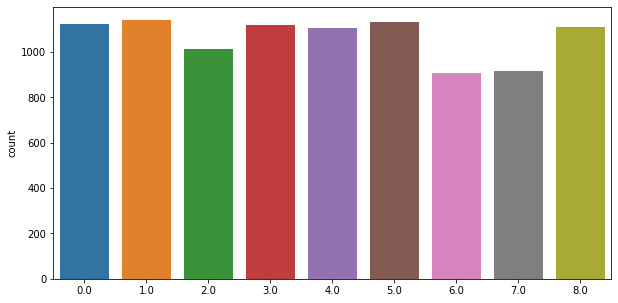

2020-04-19 21:51:05.982913 Epoch 1, Training loss 2.197154144446055
2020-04-19 21:52:12.401387 Epoch 10, Training loss 0.41408925627668697
2020-04-19 21:53:26.013381 Epoch 20, Training loss 0.21279345592483878
2020-04-19 21:54:39.814588 Epoch 30, Training loss 0.14548258669674397
2020-04-19 21:55:53.522544 Epoch 40, Training loss 0.11619524269675215
2020-04-19 21:57:07.352285 Epoch 50, Training loss 0.0955779729411006
2020-04-19 21:58:21.443332 Epoch 60, Training loss 0.08469312886397044
2020-04-19 21:59:35.930806 Epoch 70, Training loss 0.07697374125321706
2020-04-19 22:00:50.265923 Epoch 80, Training loss 0.06763496929003547


In [69]:
model, train_loader, val_loader = train(X,y)

In [71]:
 validate(model, train_loader, val_loader)

Accuracy train: 0.98
Accuracy val: 0.78


CNN for Class test set  Overall average:  0.8560371517027864
CNN for Class test set   A  accuracy:  0.9565217391304348
CNN for Class test set   B  accuracy:  0.9701492537313433
CNN for Class test set   C  accuracy:  0.9636363636363636
CNN for Class test set   D  accuracy:  0.9803921568627451
CNN for Class test set   E  accuracy:  0.8507462686567164
CNN for Class test set   F  accuracy:  0.8870967741935484
CNN for Class test set   G  accuracy:  0.9759036144578314
CNN for Class test set   H  accuracy:  0.8666666666666667
CNN for Class test set   I  accuracy:  0.5606060606060606
[[66  0  1  2  0  0  0  0  0]
 [ 0 65  0  0  0  1  0  1  0]
 [ 0  1 53  0  1  0  0  0  0]
 [ 0  0  0 50  1  0  0  0  0]
 [ 2  2  4  1 57  0  0  0  1]
 [ 2  2  1  0  1 55  0  1  0]
 [ 0  1  0  0  0  0 81  0  1]
 [ 0  0  2  0  1  1  3 52  1]
 [ 7  6 13 11 18  3  0  0 74]]


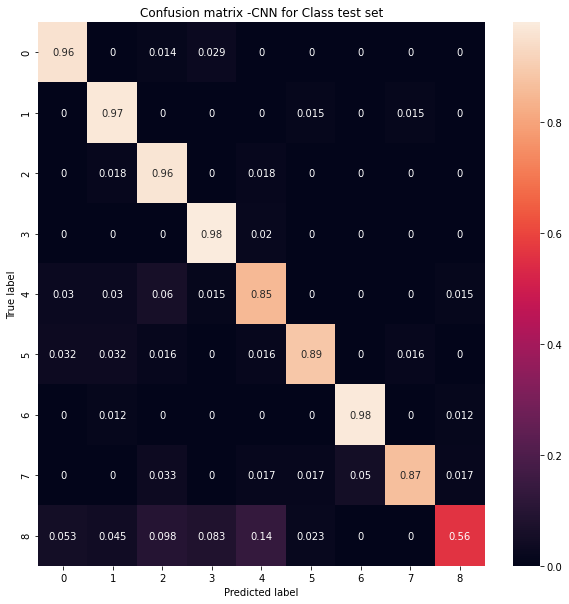

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


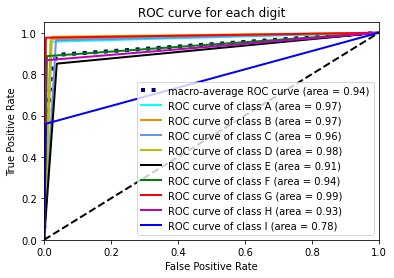

In [70]:
X_norm = []
for i in range(X.shape[0]):
        img = X[i]
        img_r = cv2.resize(img, dsize=(50,50), interpolation=cv2.INTER_CUBIC)
        img_g = rgb2gray(img_r)
        img_1d = img_g.flatten()
        X_norm.append(img_1d)
X_norm = np.asarray(X_norm)

# Convert characters to numbers
y = np.squeeze(y)
ulabels = np.unique(y)
y_num = np.zeros(len(y))
for i in range(len(ulabels)):
      y_num[y == ulabels[i]] = i

# Splitting
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(
          X_norm, y_num, test_size = 0.35, random_state = 4) 

possibleLabels = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

X_2d = []
for i in X_val_class:
    X_2d.append(i.reshape(1, 50, 50))
X_2d = np.array(X_2d)
    
        # Convert data & labels from numpy to PyTorch format
data = torch.FloatTensor(X_2d)
        #data = data.permute(0,3,1,2)        
labels = torch.LongTensor(y_val_class)  

predictions = model(Variable(data))
#net.test(torch.max(predictions.data, 1)[1], labels)
performMetrics(predictions.data, labels, possibleLabels, "CNN for Class test set")

In [0]:
def convert2DTo1D(arr):
    if (len(arr) == 0):
        return;
    temp = np.array(arr[0]);
    for i in range(1,len(arr)):
        temp = np.append(temp, arr[i]);
    return temp

#Convert all the photos into 1D arrays
def convertAllPhotosTo1DArrays(threeDArr):
    if (len(threeDArr.shape) < 2):
        print("Array size is not 3D")
        return threeDArr;
    twoDArr = np.zeros(shape=(len(threeDArr),10000))
    for i in range(len(threeDArr)):
        twoDArr[i] = convert2DTo1D(threeDArr[i])
    return twoDArr

#Calculates the accuracy for each class
def createAccuracyPerClassArray(y_actual, y_predict, labels):
    correct = [0] * len(labels)
    total = [0] * len(labels)
    for i in range(len(y_actual)):
        if y_actual[i] == y_predict[i]:
            correct[labels.index(y_actual[i])] += 1
        total[labels.index(y_actual[i])] += 1
    accuracy = [0] * len(labels)
    for i in range(len(correct)):
        if (total[i] == 0):
          accuracy[i] = 0
        else:
          accuracy[i] = correct[i] / total[i]
    return accuracy

def makeAccuracyGraph(arr, training, startingNum=0, title=""):
    plt.figure(figsize=(10,6))
    plt.plot(range(startingNum, startingNum + len(arr)),arr,color='blue', linestyle='dashed', marker="o",
            markerfacecolor='red', markersize=10, label="Test")
    plt.plot(range(startingNum, startingNum + len(arr)),arr,color='green', linestyle='-.', marker="o",
            markerfacecolor='purple', markersize=10, label="Training")
    plt.title("Accuracy vs" + title)
    plt.xlabel(title)
    plt.ylabel("Accuracy")

#Prints the perclass accuracy
def printPerClassAccuracies(accuracy, labels, title=""):
      for i in range(len(accuracy)):
        print(title, " ", labels[i], " accuracy: ", accuracy[i])
    
#Prints the overall accuracy and the per class accuracy for each N 
#(for example, if I were testing K different neighbors for KNN, the arr would be len(K), the perClass would be a 2D array with [K, len(labels)])
def printAccuracies(arr, training, perClass, labels, startingNum = 0, title=""):
    for i in range(len(arr)):
        print(title, " - ", startingNum+i, " overall accuracy: ", arr[i])
        print("Per class accuracies for ", title, startingNum+i)
        printPerClassAccuracies(perClass[i],labels)

    makeAccuracyGraph(arr, training, startingNum, title)

#Metrics function
def performMetrics(y_te, y_pre, labels, name=""):
    y_test = [-1] * y_te.shape[0] #Create a N sized array, where N is the size of the training set
    i_max = -1000
    for i in range(len(y_te)):
      i_max = -1
      for j in range(len(y_te[i])): 
        if y_te[i][j] > i_max:
          i_max = y_te[i][j]
          y_test[i] = j
      #JD6 We could easily just test here that if it is less than a threshold leave it at -1
      #y_test[i] = j #if i_max < threshold

    y_predict = y_pre.tolist()

    #Converting them to be the letters
    for i in range(len(y_predict)):
      y_test[i] = labels[y_test[i]]
      y_predict[i] = labels[y_predict[i]]

    count = 0
    for i in range(len(y_test)):
        count += 1 if (y_test[i] == y_predict[i]) else 0
    print(name, " Overall average: ", (count/len(y_test)))

    perClass = createAccuracyPerClassArray(y_test,y_predict,labels)
    printPerClassAccuracies(perClass, labels, name)

    #Confusion Maxtrix - Lecture 10
    C = metrics.confusion_matrix(y_test,y_predict,labels=labels)
    print(C)
    C_scaled = list()
    #Scaling each value
    #JD6, may have to put an array of possible labels here?
    for row in range(0,len(C)):
        total = 0
        C_scaled.append(list())
        for col in range(0,len(C[row])):
            total += C[row][col] 
        for col in range(0,len(C[row])):
            C_scaled [row].append(C[row][col] / total) 
            #Divide each one to get the %

    plt.figure(figsize = (10,10))
    ax = plt.axes()
    sns.heatmap(C_scaled, annot=True)

    ax.set_title("Confusion matrix -" + name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()

    #Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Compute ROC curve and ROC area for each class
    lw = 2
    n_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        #From Dr. Silvia's OH
        y_t = [True] * len(y_test)
        y_p = [True] * len(y_test)
        for j in range(len(y_test)):
          y_t[j] = 1 if (y_test[j] == labels[i]) else 0
          y_p[j] = 1 if (y_predict[j] == labels[i]) else 0
        fpr[labels[i]], tpr[labels[i]], _ = metrics.roc_curve(y_t, y_p)
        roc_auc[labels[i]] = metrics.auc(fpr[labels[i]], tpr[labels[i]])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[labels[i]] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[labels[i]], tpr[labels[i]])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', "y", "k", "g", "r", "m", "b", "c"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[labels[i]], tpr[labels[i]], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels[i], roc_auc[labels[i]]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each digit')
    plt.legend(loc="lower right")
    plt.show()